# C1 - Introduction to Human and Computer Vision
## Week 2 - Draft Notebook

In [1]:
import os
import re
import matplotlib.pyplot as plt

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week2')
os.chdir(BASE_PATH)
BASE_PATH

'/Users/arnaubarrera/Desktop/MSc Computer Vision/C1. Intro to Human and CV/Team5/week2'

### Load datasets

In [2]:
from src.image_dataset import ImageDataset, ColorSpace

DATA_DIRECTORY = '../data'

interval = 7

# Load the Cropped Dataset (QueryDataset) and Background Dataset (BGDataset)
BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', colorspace=ColorSpace.CieLab, interval=interval)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.CieLab, interval=interval)
# BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd2_w2', colorspace=ColorSpace.CieLab, interval=interval)

### Task 1 - Block and hierarchical histograms

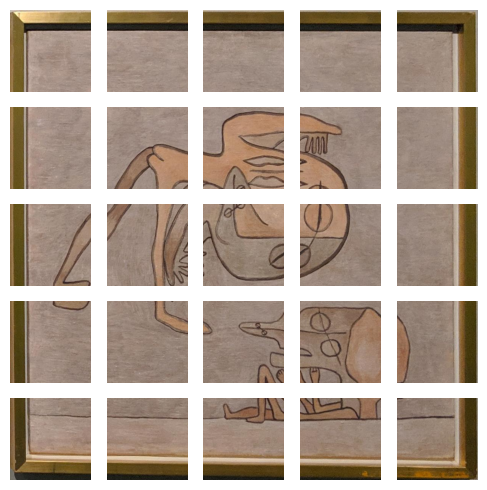

In [3]:
import importlib
import numpy as np
import src.image_block_descriptor

from src.image_block_descriptor import ImageBlockDescriptor
importlib.reload(src.image_block_descriptor) 

image = ImageBlockDescriptor(QueryDataset.images[0].path)

ROWS = 5
COLUMNS = 5

# Divide the image into blocks
image_blocks = image.divide_image_into_blocks(ROWS, COLUMNS)

# Update histogram_descriptor
image.compute_image_histogram_descriptor(interval=interval, rows=ROWS, columns=COLUMNS)

# ----- Plot the Image Blocks -----
fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(COLUMNS, ROWS))
    
for i in range(ROWS):
    for j in range(COLUMNS):
        axes[i, j].imshow(image_blocks[i][j])
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

In [4]:
len(image.histogram_descriptor), len(image.histogram_descriptor[0]), image.histogram_descriptor[0][0].shape

(5, 5, (108,))

Notice how:

255 // 10 intervals = 25 bins and

25 bins*3 image channels = 75 concatenated color channels for each block

#### Spatial Pyramid Representation

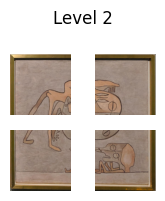

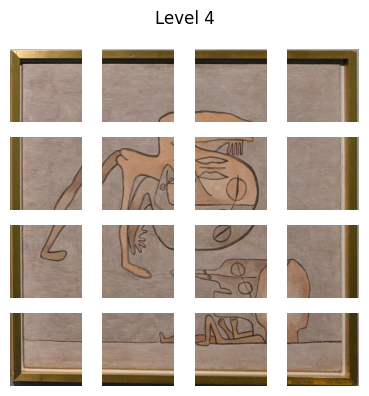

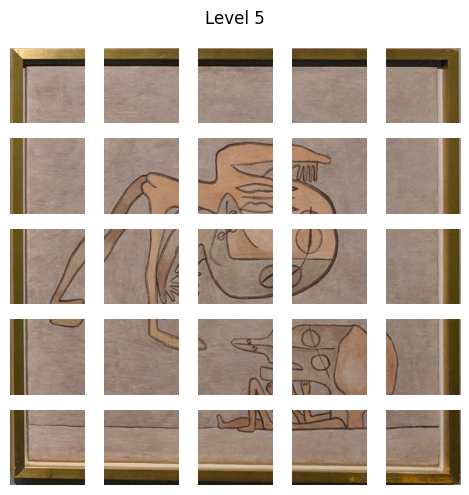

In [5]:
# Let's start by square grids

# The level indicates the size of the grid used to divide the image by block. For example, level 4 indicates we divide the image with a grid of 4x4 blocks
levels = [2, 4, 5]

for level in levels:
    ROWS = level
    COLUMNS = level
    
     # Divide the image into blocks
    image_blocks = image.divide_image_into_blocks(ROWS, COLUMNS)

    # Update histogram_descriptor
    image.compute_image_histogram_descriptor(interval=interval, rows=ROWS, columns=COLUMNS)

    # ----- Plot the Image Blocks -----
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(COLUMNS, ROWS))
        
    for i in range(ROWS):
        for j in range(COLUMNS):
            axes[i, j].imshow(image_blocks[i][j])
            axes[i, j].axis('off') 

    plt.suptitle(f'Level {level}')
    plt.tight_layout(w_pad=0.1)
    plt.show()



### Task 2 - Evaluate retrieval results

#### Block-based Histograms

In [6]:
import pickle

# Get ground truth
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

In [24]:
from src.evaluation import compute_results_by_similarity, compute_spatial_pyramid
from src.metrics import SimilarityType, DistanceType

metric = SimilarityType.bhattacharyya
res = compute_results_by_similarity(
    BDDataset, QueryDataset, ground_truth, metric,
)

result = {}
result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

{'bhattacharyya_similarity': {'mapk1': 0.6333333333333333, 'mapk5': 0.7083333333333334}}


#### Spatial Pyramid Representation

In [26]:
levels = [2, 4]

res=[]
for level in levels:    
    BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', colorspace=ColorSpace.CieLab, interval=interval, rows=level, columns=level)
    QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.CieLab, interval=interval, rows=level, columns=level)

    res_i = compute_spatial_pyramid(
        BDDataset, QueryDataset, ground_truth, metric,
    )

    res.append(res_i)

result = {}
result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

TypeError: list indices must be integers or slices, not str

In [21]:
res_i[0]

KeyError: 0

### Task 3 - Background removal

#### Plot Original / Groundtruth / Obtained Mask

In [ ]:
import importlib
import cv2
import src.background_removal

# Reload after making changes
importlib.reload(src.background_removal) 
from src.background_removal import get_mask_and_foreground

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w2') if f.endswith('.png')]

# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
for i in range(0, 4):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd2_w2', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Get foreground and mask
    foreground, mask = get_mask_and_foreground(image)
    plt.subplot(1, 4, 3)
    plt.imshow(foreground)
    plt.title('Foreground')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

#### Save masks

In [7]:
FOREGROUND_DIR = "data_results/foregrounds"
MASK_DIR = "data_results/masks"

In [37]:
for path in [FOREGROUND_DIR, MASK_DIR]:
    if not os.path.exists(path):
        os.makedirs(path)

def get_image_filename(path):
    """
    Returns image filename (e.g. 00000, 00001, ...)
    """
    base_name = os.path.basename(path)
    file_name = os.path.splitext(base_name)[0]
    return file_name

# Save Foreground and Masks results
for i in range(0, len(background_files)):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)
    filename = get_image_filename(BGDataset.images[i].path)

    # Get the foreground and mask
    foreground, mask = get_mask_and_foreground(image)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, f"{filename}.png")
    mask_path = os.path.join(MASK_DIR, f"{filename}.png")

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

### Task 4 - Masks evaluation

In [ ]:
import pandas as pd
import src.background_removal

# Reload after making changes
importlib.reload(src.background_removal) 
from src.background_removal import evaluate_masks

# First directory needs to be updated!
precision, recall, f1_score = evaluate_masks(f'{MASK_DIR}', f'{DATA_DIRECTORY}/qsd2_w2')

results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [precision, recall, f1_score]
})
print(results)

### Task 5 - Retrieval

### Task 6 - .pkl results generation